In [11]:
#DEPENDENCIES 
import numpy as np
import pandas as pd
from pandas import DataFrame
from math import sqrt

import statsmodels.api as sm
from scipy import stats
import scipy.stats as ss
from statsmodels.graphics.gofplots import qqplot

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

# EDA

In [2]:
df = pd.read_csv('kc_house_data.csv', sep=',')
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890.0,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715.0,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060.0,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050.0,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890.0,0,2003,0,98038,47.3684,-122.031,2390,7570


In [3]:
price = df['price']
print('Average house price: ' + str(price.mean()))
print('Median house price: ' + str(price.median()))
print('Shape of dataframe (# rows, # cols): ' + str(df.shape))

Average house price: 540088.1417665294
Median house price: 450000.0
Shape of dataframe (# rows, # cols): (21613, 21)


# Normality Tests & Transformations

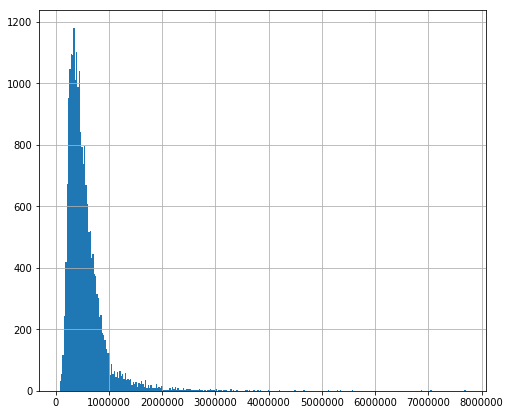

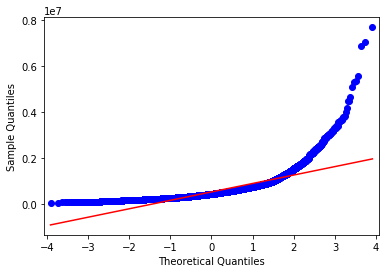

In [4]:
target = df.loc[:,'price']

fig, ax = pyplot.subplots(figsize=(8,7))
target.hist(bins=300)
qqplot(target, line='s')
pyplot.show()

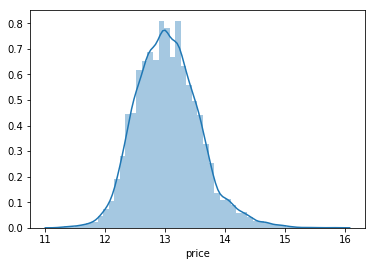

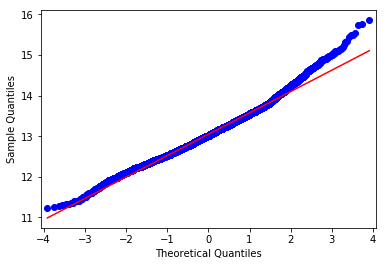

In [5]:
target_log = np.log(target)
sns.distplot(target_log)
qqplot(target_log, line='s')
pyplot.show()

# Check for Nulls

In [6]:
df.isnull().values.any() #True - there are null values
countNaN = len(df) - df.count() #count of NaN values = count of all values (len(df)) - count of non-NaN values (df.count)
display(countNaN) #display NaN counts for each column

df['sqft_above'] = df['sqft_above'].fillna(df['sqft_above'].mean()) #fill 2 missing sqft_above values with mean of column

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Feature Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001833B3FCEB8>,
      dtype=object)

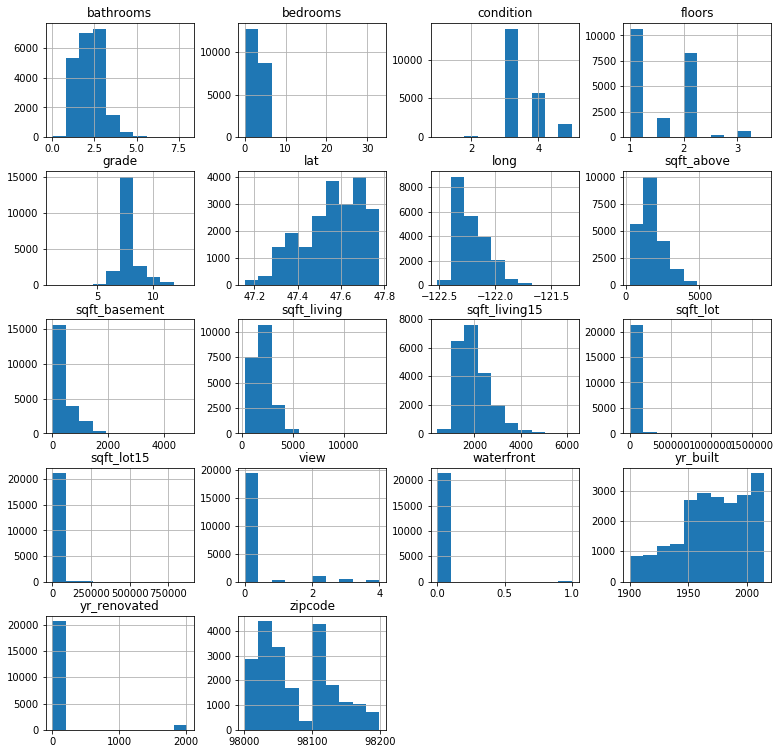

In [7]:
features = df.iloc[:,3:]
features.hist(figsize=(13,13)) #plot distributions of features

In [8]:
print(list(features.columns.values))

continuous_features = df.loc[:,['bedrooms','bathrooms','sqft_living','sqft_living15','sqft_lot','sqft_lot15','sqft_above',
                               'sqft_basement','yr_built','yr_renovated','lat','long']]

ordinal_features = df.loc[:,['condition','grade']]

nominal_features = df.loc[:,['waterfront','view','zipcode']]

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


# Outlier Detection

In [9]:
from scipy.stats import zscore

#consider the distribution of the data before identifying outliers - normalize with a transformation if necessary
def get_outliers(ser, method='IQR', z_threshold=3, drop=False):
    """Takes a Pandas Series as input and determines outliers using the IQR or Z score method (method='Z').
    Specify drop=True to remove the outlier values from the Series - if drop=True, output is the new Series.
    If drop=False, output is a list of indexes of the outliers
    """
    if method == 'IQR':
        #Use interquartile range method to identify outliers in the series
        Q1 = ser.quantile(0.25)
        Q3 = ser.quantile(0.75)
        IQR = Q3 - Q1 #interquartile range
        #a value is an outlier if it is less than Q1 - 1.5IQR, OR if it is greater than Q3 + 1.5IQR
        outlier_bools = (target < (Q1 - 1.5 * IQR)) | (target > (Q3 + 1.5 * IQR)) #Series of True and False; True if outlier   
    elif method == 'Z':
        ser_z = list(ser.pipe(zscore))
        outlier_bools = []
        for x in ser_z:
            if x < -z_threshold or x > z_threshold:
                outlier_bools.append(True)
            else:
                outlier_bools.append(False)        
    outlier_idxs = [] #this list stores the indexes of all rows with an outlier
    for idx,val in enumerate(outlier_bools):
        if val == True:
            outlier_idxs.append(idx) 
    print('Number of outliers: ' + str(len(outlier_idxs)))
    print('Proportion of outliers in data: ' + str(len(outlier_idxs)/len(ser)))
    if drop==True:
        print('Length of original Series: ' + str(len(ser)))
        ser = ser.drop(ser.index[outlier_idxs])
        print('Length without outliers: ' + str(len(ser)))
        return ser    
    elif drop==False:
        return outlier_idxs

In [12]:
print('Z score outlier detection for dependent variable Price:')
z_score_outliers = get_outliers(target_log, method='Z', z_threshold=3, drop=False)
print('\n')



#influence statistics from SAS regression model
influence = pd.read_csv('influence_stats_no_pca.csv', sep=',') #influence statistics for each record in the 14 variable model
influence = influence.loc[:,['cooksd','lev','dffits']]

high_lev_points = influence.loc[influence['lev'] > (2*14/df.shape[0])]
high_lev_points = high_lev_points.index.values
print('# of high leverage points: ' + str(len(high_lev_points)))

high_cooksd = influence.loc[influence['cooksd'] > (4/df.shape[0])]
high_cooksd = high_cooksd.index.values
print('# of high cooksd points: ' + str(len(high_cooksd)))

high_dffits = influence.loc[influence['dffits'] > (2*sqrt(14+1) / sqrt(df.shape[0] - 14 - 1))]
high_dffits = high_dffits.index.values
print('# of high dffits points: ' + str(len(high_dffits)))
                
    
    
print('\n')
influentials = [x for x in high_lev_points if x in high_cooksd and x in high_dffits]
print('# of influential points: ' + str(len(influentials)))

influential_and_outlier = [x for x in high_lev_points if x in high_cooksd and x in high_dffits and x in z_score_outliers]
print('# of influential points which are also z score outliers: ' + str(len(influential_and_outlier)))

Z score outlier detection for dependent variable Price:
Number of outliers: 170
Proportion of outliers in data: 0.007865636422523482


# of high leverage points: 2847
# of high cooksd points: 1268
# of high dffits points: 610


# of influential points: 440
# of influential points which are also z score outliers: 39


# Correlation Analysis

## Continuous Variable Correlations

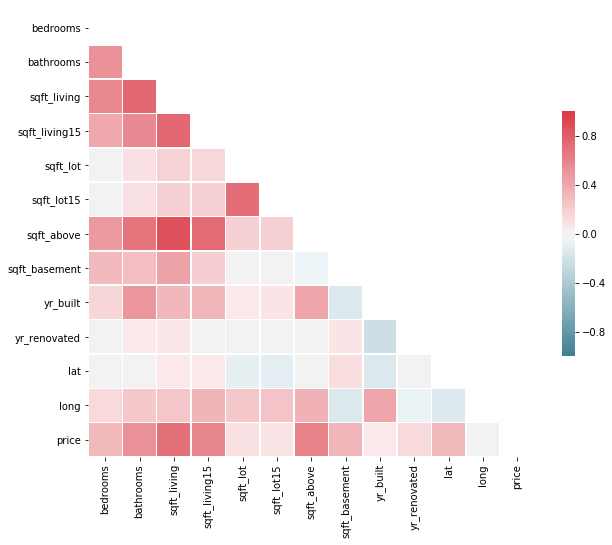

In [13]:
cont_with_target = pd.concat([continuous_features,target],axis=1)
cont_corr = cont_with_target.corr()
# display(cont_corr)


def corr_heatmap(corr_matrix,vmin,vmax):#use vmin and vmax to specify the range of correlation values (e.g [-1,1])
    """Takes a pandas correlation matrix as input and generates a heatmap"""
    # Generate a mask for the upper triangle of heat map
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=vmax, vmin=vmin, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
corr_heatmap(cont_corr,vmin=-1,vmax=1)

## Categorical Variable Correlations

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


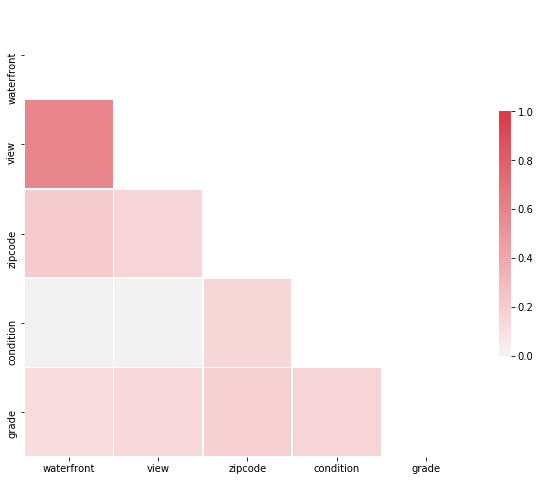

In [14]:
#this cell applies a correlation technique specific to categorical variables

categorical_features = pd.concat([nominal_features,ordinal_features],axis=1)

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.""" 
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


for col in range(0,categorical_features.shape[1]): #loop through all the nominal feature columns
    categorical_features.iloc[:,col] = categorical_features.iloc[:,col].astype('category') #convert them to 'category' type
    
def cat_corr_matrix(cat_features): 
    """converts a pandas dataframe of categorical nominal features to a Cramer's V Categorical Correlation Matrix"""
    corr_list = []
    for i in range(0,cat_features.shape[1]):
        for j in range(0,cat_features.shape[1]):
            if i == j:
                corr_list.append(1) #a feature's correlation with itself is 1
            else:
                confusion_matrix = pd.crosstab(cat_features.iloc[:,i],cat_features.iloc[:,j]).as_matrix()
                corr_list.append(cramers_corrected_stat(confusion_matrix))

    #create a list of lists for every feature's corelation with every other feature (including itself)
    corr_vectors = [corr_list[x:x+cat_features.shape[1]] for x in range(0,len(corr_list),cat_features.shape[1])] 
    
    cat_corr_matrix = DataFrame.from_records(corr_vectors) #convert the list of lists to a dataframe
    
    col_names = list(cat_features.columns.values)
    cat_corr_matrix.columns = col_names
    cat_corr_matrix.index.rename = col_names
        
    return cat_corr_matrix

categorical_corr = cat_corr_matrix(categorical_features)
categorical_corr.rename(index={0:'waterfront',1:'view',2:'zipcode',3:'condition',4:'grade'}, inplace=True)

corr_heatmap(categorical_corr,vmin=0,vmax=1)

## Categorical Correlations with Target

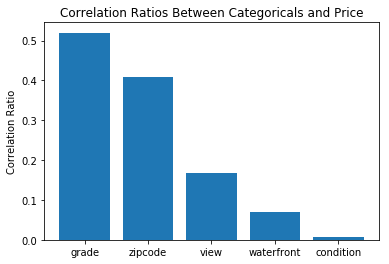

In [15]:
#CORRELATION RATIO: https://en.wikipedia.org/wiki/Correlation_ratio
#use Correlation Ratio to find the relationship between categorical features & a continuous target
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta


corr_ratios = []
feature_names = list(categorical_features.columns.values)
for feature in feature_names:
    corr_ratios.append(correlation_ratio(categorical_features[feature],target))
    
tuples = zip(feature_names, corr_ratios)

sorted_tuples = sorted(tuples,key=lambda x:(-x[1],x[0]))

labels = [x[0] for x in sorted_tuples]
ratios = [x[1] for x in sorted_tuples]
x_pos = np.arange(len(labels)) 
   
plt.bar(x_pos, ratios,align='center')
plt.rcParams["figure.figsize"] = (10,10)
plt.xticks(x_pos, labels) 
plt.title('Correlation Ratios Between Categoricals and Price')
plt.ylabel('Correlation Ratio')
plt.show()